In [41]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (8, 8)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [81]:
%%R

require('tidyverse')
require("emojifont")
require("ggrepel")
require("ggtext")
require("ggforce")
source('functions.R')

### My Hypothesis Question: 
**Do white Grammys nominees stand a higher chance of winning than nominees of color?**


In [82]:
# Import data
df = pd.read_csv("musicians-matched.csv")
df = df[['id','year','work','category','status','cleaned_musician','ethnicity','status/ethnicity','total_percentage']]
df.head()

,id,year,work,category,status,cleaned_musician,ethnicity,status/ethnicity,total_percentage
0,1,2022,We Are,album-of-the-year,winner,Jon Batiste,UR,UR winner,0.666667
1,2,2022,Love for Sale,album-of-the-year,nominee,Tony Bennett Lady Gaga,white,white nominee,0.666667
2,3,2022,Justice,album-of-the-year,nominee,Justin Bieber,white,white nominee,0.666667
3,4,2022,Planet Her,album-of-the-year,nominee,Doja Cat,UR,UR nominee,0.666667
4,5,2022,Happier Than Ever,album-of-the-year,nominee,Billie Eilish,white,white nominee,0.666667


### 1. Exploratory Analysis

In [90]:
# a pivot table to lookup chance of winning by category

pivot = pd.pivot_table(df, values='id', 
                            index=['category','ethnicity'], 
                            columns='status', 
                            aggfunc='count',
                            fill_value=0)

pivot['total'] = pivot['nominee']+pivot['winner']
pivot['chance'] = pivot['winner']/pivot['total']

# pivot.reset_index(inplace=True)
pivot

status                        nominee  winner  total    chance
category           ethnicity                                  
album-of-the-year  UR              63      11     74  0.148649
                   white           92      23    115  0.200000
best-new-artist    UR              70      13     83  0.156627
                   white           85      21    106  0.198113
record-of-the-year UR              79      11     90  0.122222
                   white           77      23    100  0.230000

In [92]:
data = [['album-of-the-year',0.15,0.2],['best-new-artist',0.16,0.2],['record-of-the-year',0.12,0.23]]

pivot_test = pd.DataFrame(data, columns=['category','UR','white'])
pivot_test

,category,UR,white
0,album-of-the-year,0.15,0.20
1,best-new-artist,0.16,0.20
2,record-of-the-year,0.12,0.23


In [80]:
# Calculate chance of winning by year
all_years = pd.pivot_table(df, values='id', 
                                index='year', 
                                columns='ethnicity', 
                                aggfunc='count',
                                fill_value=0)

all_years.reset_index(inplace=True)
all_years.head()

ethnicity,year,UR,white
0,1990,6,9
1,1991,6,9
2,1992,6,9
3,1993,5,10
4,1994,5,10


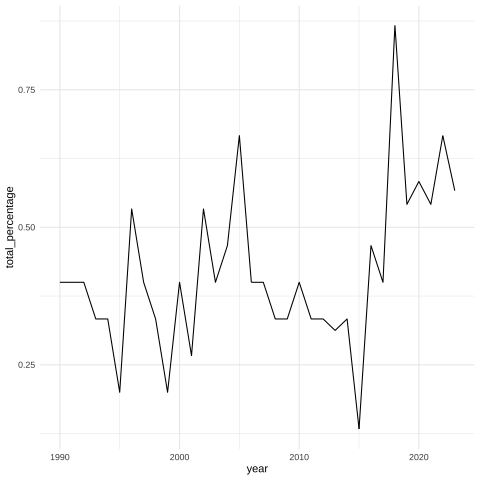

In [47]:
%%R -i df

# UR artists' chance of winning across all 3 categories over the years.
ggplot(df,aes(y=total_percentage,x=year))+
    geom_line()+
    theme_minimal()

In [71]:
# calculate chance of winning by artist
musician_pivot = pd.pivot_table(df, values='id',
                            index=['cleaned_musician','ethnicity'], 
                            columns='status', 
                            aggfunc='count',
                            fill_value=0)

musician_pivot['total'] = musician_pivot['nominee']+musician_pivot['winner']
musician_pivot['chance'] = musician_pivot['winner']/musician_pivot['total']


musician_pivot.reset_index(inplace=True)
musician_pivot

status,cleaned_musician,ethnicity,nominee,winner,total,chance
0,50 Cent,UR,1,0,1,0.000
1,Abba,white,3,0,3,0.000
2,Ace of Base,white,1,0,1,0.000
3,Adele,white,3,5,8,0.625
4,Alabama Shakes,UR,2,0,2,0.000
...,...,...,...,...,...,...
346,fun featuring Janelle Monae,UR,1,0,1,0.000
347,kd lang,white,2,0,2,0.000
348,soundtrack,UR,1,0,1,0.000
349,soundtrack,white,1,0,1,0.000


In [108]:
# Summary of white nominees' chance of winning
musician_pivot[musician_pivot['ethnicity'] == 'white'].chance.describe()

count    189.000000
mean       0.173236
std        0.332548
min        0.000000
25%        0.000000
50%        0.000000
75%        0.200000
max        1.000000
Name: chance, dtype: float64

In [109]:
# Summary of non-white nominees' chance of winning
musician_pivot[musician_pivot['ethnicity'] == 'UR'].chance.describe()

count    162.000000
mean       0.150309
std        0.339663
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: chance, dtype: float64

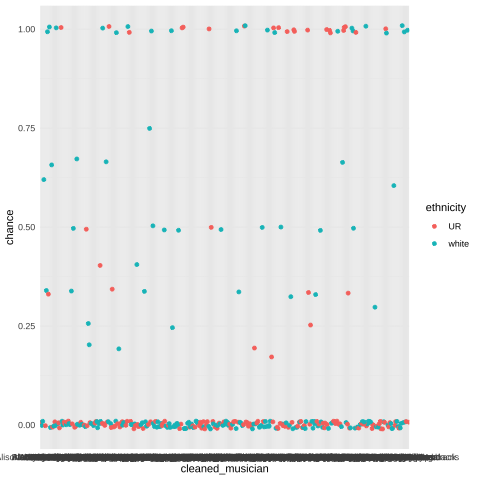

In [73]:
%%R -i musician_pivot
# plot each musician's chance of winning across category, and their ethnicity
ggplot(musician_pivot,aes(y=chance,x=cleaned_musician,color=ethnicity))+
    geom_jitter()+
    theme_minimal()

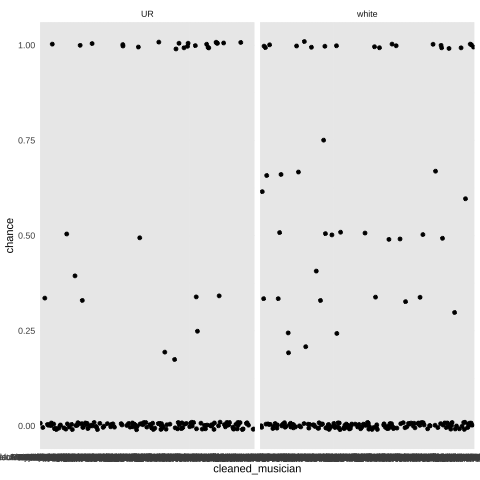

In [110]:
%%R
# white and non-white artist's chance of winning across category, faceted

ggplot(musician_pivot
       ,aes(y=chance,x=cleaned_musician))+
    geom_jitter()+
    theme_minimal()+
    facet_wrap(~ethnicity)

### 2. Journalistic —> Statistical Inquiry

- null hypothesis: There is no difference between white nominees and non-white nominees' chance of winning.
- alternative hypothesis: White nominees on average stand higher chance of winning than non-white nominees.

The statistical test I'm applying for my hypothesis is Chi-Square test and t test. 

In [112]:
%%R  -i musician_pivot
non_white <- musician_pivot%>%filter(ethnicity == "UR")
white <- musician_pivot%>%filter(ethnicity == "white")
# T test individual artist's chance of winning 
t.test(non_white$chance, white$chance)


	Welch Two Sample t-test

data:  non_white$chance and white$chance
t = -0.63656, df = 338.53, p-value = 0.5248
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.09377470  0.04791932
sample estimates:
mean of x mean of y 
0.1503086 0.1732363 



In [94]:
%%R -i pivot_test
# Chi Square test chance of winning across category
chisq.test(pivot_test$UR, pivot_test$white, correct=FALSE)


	Pearson's Chi-squared test

data:  pivot_test$UR and pivot_test$white
X-squared = 3, df = 2, p-value = 0.2231



#### Conclusion:
- The p-values from both test results suggest are not statistically significant enough to reject my null hypothesis. 
- Simply by looking at the results, it is possible that the observed difference in chance of winning is a result of sole chance.
- By looking at the summary stats, however, white nominees on average do stand a slightly higher chance of winning individually and across category.
- Some caveats of my data: I do have a small smaple size (compared with all grammys nominations across all categories). 
- In addition, I did not separate artists for tracks that featured both white and non-white artists (e.g. "Old Town Road", a track by Lil Nas X-a black artist-featured Billy Ray Cyrus, who is white, is marked as "UR" in the dataset). The results might be different if I break down the artists on these tracks. 


I am also having trouble interperting p-values that are > 0.05. Does a larger-than-0.05 p-value mean that my hypothesis is false? Or does it suggest a possibility that the hypothesis might be true?

### 3. Statistical —> Journalistic Inquiry
Reporting Qs that my exploratory plots raised:
- Question relating to statistical test (Qs for statisticians): 
    - Am I running the appropriate statistical tests for my hypothesis? 
    - Are there any issues in the way the data is classified? 
    - Should I restructure my data or classify my data differently in order to represent the reality of grammys nomination's diversity with the dataset?
    - What does the difference in the average chance of winning suggest? How should I interpret what I'm seeing here?
- What is the nomination & voting process of the grammys like?
- What sorts of criterias were used to determine which nominee wins the grammys? For instance, quantitative evalutions such as number of record sales and ranking on charts (like Billboard 100); or qualitative evaluations such as critic's opinion and creative value? 
- Were there past accusations relating to racial diversity and representation against the Grammys? What kind of claims did the accusers raised? 
- Why did the academy added number of nominees in each category in recent years?
- Had the recording academy ever addressed problems regarding racial diversity in their nomination process/voting process? If so, did their acknowledgement and refomative actions have an effect on the racial demographic of nominees and winners?

Next step:
1. Contact statisticians that have worked with award nomination data to go over my dataset for possible improvement of data strcuture, as well as advice on the statistical tests used in my rough analysis. Potential source: the [Inclusion Institute at USC](https://assets.uscannenberg.org/docs/aii-inclusion-recording-studio-20200117.pdf).
2. Reach out to journalists who have covered this topic to learn about their findings about racial diversity of the grammys.
3. Reach out to advocacy groups and activists for diversity in the Recording Academy.
4. Reach out to the recording academy for their detailed number of racial demographic of all their general members and voting members.

*Appendix: My data studio project using this dataset: https://xinyitu.github.io/grammys/*